In [1]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame
from matplotlib import gridspec
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
%matplotlib inline

## Loading in the data

Comment out the data files that you don't want to use.

In [2]:
filename = 'data/N-CMAPSS_DS01-005.h5'
# filename = 'data/N-CMAPSS_DS04.h5'
# filename = 'data/N-CMAPSS_DS08c-008.h5'

In [3]:
# time tracking
t = time.process_time()  

# loading data
with h5py.File(filename, 'r') as hdf:
        
        # development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.03854166666666667

W shape: (7641868, 4)
X_s shape: (7641868, 14)
X_v shape: (7641868, 14)
T shape: (7641868, 10)
A shape: (7641868, 4)


In [4]:
# creating the dataframes for training
df_A_train = DataFrame(data=A_dev, columns=A_var)             # auxiliary information
df_W_train = DataFrame(data=W_dev, columns=W_var)             # operative conditions 
df_X_s_train = DataFrame(data=X_s_dev, columns=X_s_var)       # sensor readings
df_X_v_train = DataFrame(data=X_v_dev, columns=X_v_var)       # virtual sensors
df_T_train = DataFrame(data=T_dev, columns=T_var)             # degradation
df_Y_train = DataFrame(data=Y_dev)                            # RUL

# creating the dataframes for testing
df_A_test = DataFrame(data=A_test, columns=A_var)             # auxiliary information
df_W_test = DataFrame(data=W_test, columns=W_var)             # operative conditions 
df_X_s_test = DataFrame(data=X_s_test, columns=X_s_var)       # sensor readings
df_X_v_test = DataFrame(data=X_v_test, columns=X_v_var)       # virtual sensors
df_T_test = DataFrame(data=T_test, columns=T_var)             # degradation
df_Y_test = DataFrame(data=Y_test)                            # RUL

# concatinated DataFrames 
df_train = pd.concat([df_W_train, df_X_s_train, df_X_v_train, df_T_train, df_Y_train, df_A_train], axis=1)
df_test = pd.concat([df_W_test, df_X_s_test, df_X_v_test, df_T_test, df_Y_test, df_A_test], axis=1)
df_total = pd.concat([df_train, df_test], axis = 0)

In [5]:
print(f"The train set of {filename} has {df_train.shape[0]} rows.")
print(f"The test set of {filename} has {df_test.shape[0]} rows.")
print(f"The combined data of {filename} has {df_total.shape[0]} rows.")

print("\n")

print(f"The units in the train set of {filename} are {df_train.unit.unique().tolist()}.")
print(f"The units in the test set of {filename} are {df_test.unit.unique().tolist()}.")

The train set of data/N-CMAPSS_DS01-005.h5 has 4906636 rows.
The test set of data/N-CMAPSS_DS01-005.h5 has 2735232 rows.
The combined data of data/N-CMAPSS_DS01-005.h5 has 7641868 rows.


The units in the train set of data/N-CMAPSS_DS01-005.h5 are [1.0, 2.0, 3.0, 4.0, 5.0, 6.0].
The units in the test set of data/N-CMAPSS_DS01-005.h5 are [7.0, 8.0, 9.0, 10.0].


In [6]:
# show train dataset
df_train.head()

,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,0,unit,cycle,Fc,hs
0,3013.0,0.376362,70.311996,522.314770,618.288596,1470.469798,1849.620676,1269.275585,19.432070,14.484611,...,0.0,-0.000604,0.0,0.0,0.0,99,1.0,1.0,1.0,1.0
1,3020.0,0.376866,70.311996,522.327145,618.296355,1470.415593,1849.519871,1269.177159,19.431385,14.484683,...,0.0,-0.000604,0.0,0.0,0.0,99,1.0,1.0,1.0,1.0
2,3025.0,0.377685,70.311996,522.371840,618.336514,1470.453853,1849.566139,1269.167353,19.435163,14.488224,...,0.0,-0.000604,0.0,0.0,0.0,99,1.0,1.0,1.0,1.0
3,3035.0,0.376992,70.399887,522.282418,618.302173,1470.650929,1850.195069,1269.518670,19.426003,14.477632,...,0.0,-0.000604,0.0,0.0,0.0,99,1.0,1.0,1.0,1.0
4,3043.0,0.377622,70.399887,522.300605,618.345228,1470.640421,1849.950988,1269.253972,19.427484,14.478114,...,0.0,-0.000604,0.0,0.0,0.0,99,1.0,1.0,1.0,1.0


### Plotting RUL

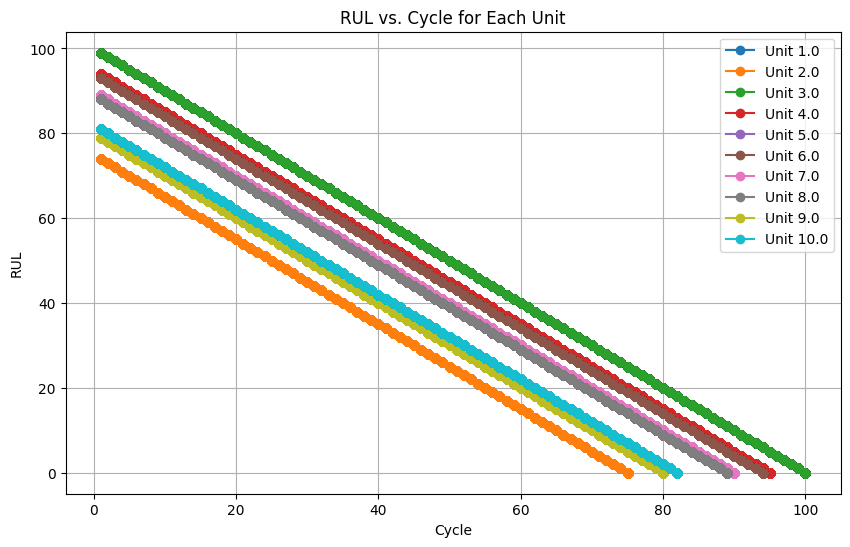

In [7]:
df = df_total

# group the data by the "unit" column
grouped_df = df.groupby('unit')

plt.figure(figsize=(10, 6))  # Set the figure size

# plot data for each unit
for unit, unit_data in grouped_df:
    plt.plot(unit_data['cycle'], unit_data[0], label=f'Unit {unit}', marker='o', linestyle='-')

# labels and title
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title('RUL vs. Cycle for Each Unit')
plt.legend()  

plt.grid(True) 
plt.show()

### Selecting reduced version of the dataframes (if needed)

In [7]:
# function to select limited number of cycles
def cycles(df, start, end):
    cycle_list = np.unique(df['cycle'])[start:end]
    filter = (df['cycle'].isin(cycle_list))
    df = df[filter]
    return df

In [8]:
# select first 10 cycles for train & test set
first10_train = cycles(df_train, 0, 10)
first10_test = cycles(df_test, 0, 10)

In [6]:
# selecting specific unit numbers (for further split of dataset for different FL clients)
sub_train = df_train.loc[df_train['unit'].isin([1, 2])]
sub_test = df_test.loc[df_test['unit'].isin([7])]

In [54]:
# save reduced frames as csv files
sub_train.to_csv('data/sub_train_DS01.csv', index=False)
sub_test.to_csv('data/sub_test_DS01.csv', index=False)

## Pre-processing Pipeline

In [8]:
# specifying what columns to remove per subset of the data (as they don't contain that failure mode)
fmodes_DS01 =  ['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod',
                'HPC_eff_mod', 'HPC_flow_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']

fmodes_DS04 =  ['LPC_eff_mod', 'LPC_flow_mod',
                'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod',
                'LPT_eff_mod', 'LPT_flow_mod']

fmodes_DS08 = []

In [9]:
def preprocessing(df, fmodes):
    '''Pre-processing pipeline for the N-CMAPSS dataset as described in the methodology'''

    # renaming RUL column
    col = list(df.columns)
    col[42]='RUL'
    df.columns = col

    # dropping columns 'P2' and 'T2'
    df = df.drop(columns = ["P2", "T2"])

    # setting rolling window size 
    window_size = 100

    # selecting columns for noise reduction (sensor measurements & virtual readings)
    to_reduce = ['TRA', 'T24', 'T30', 'T48', 'T50', 'P15', 'P21', 'P24',
       'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'T40', 'P30', 'P45', 'W21',
       'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC',
       'phi', 'fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod',
       'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod',
       'LPT_eff_mod', 'LPT_flow_mod']
    
    # part of dataframe that doesn't need noise reduction
    no_noise = df[['alt', 'Mach', 'RUL', 'unit', 'cycle', 'Fc', 'hs']]

    # calculate rolling average for each column base on window
    rolling_avg_df = df[to_reduce].rolling(window=window_size).mean()

    # fill in nan values with the original value 
    for col in to_reduce:
        rolling_avg_df.fillna({col: df[col]}, inplace=True)

    # concatenate both parts of dataframe back together 
    df_reduced = pd.concat([no_noise, rolling_avg_df], axis = 1)

    # calculating T30 - T24 & adding to dataframe
    df_reduced["dT_30_24"] = abs(df_reduced.T30 - df_reduced.T24)

    # calculating T50 - T40 & adding to dataframe 
    df_reduced["dT_50_40"] = abs(df_reduced.T50 - df_reduced.T40)

    # applying z-score normalization 
    df_reduced[to_reduce + ["dT_30_24", "dT_50_40"]] = df_reduced[to_reduce + ["dT_30_24", "dT_50_40"]].apply(zscore)

    # dropping failure modes not in current subset
    df_reduced = df_reduced.drop(columns = fmodes)

    return df_reduced


In [10]:
# pre-process data & give inactive failure modes of subset as input
df_train_processed = preprocessing(df_train, fmodes_DS01)
df_test_processed = preprocessing(df_test, fmodes_DS01)

Text(0.5, 1.0, 'Pre-Processed Feature Correlation with RUL')

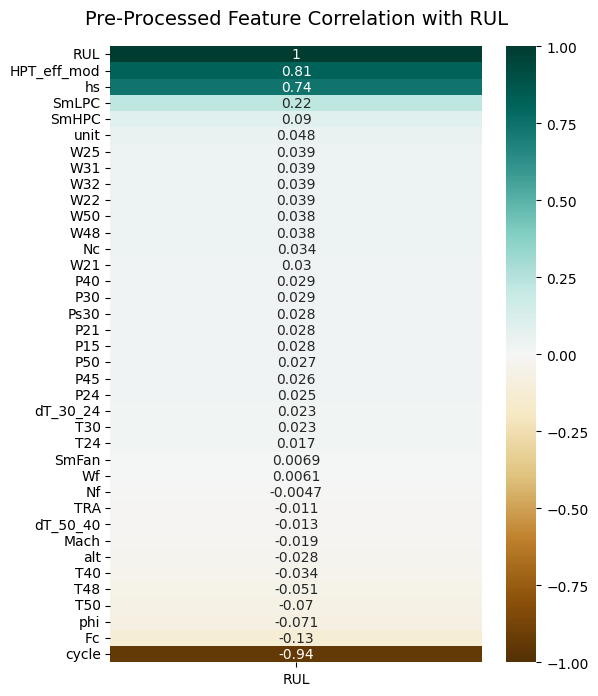

In [11]:
# correlation heatmap of RUL against all features
plt.figure(figsize=(6, 8))
sensor_readings_heatmap = sns.heatmap(df_train_processed.corr()[['RUL']].sort_values(by='RUL', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
sensor_readings_heatmap.set_title('Pre-Processed Feature Correlation with RUL', fontdict={'fontsize':14}, pad=16)

In [12]:
def low_correlation(df, treshold = 0.1):
    """Filtering out features that have an exteremely low correlation with the target value RUL"""

    # calculate correlations
    correlations = df.corr()[['RUL']]

    # list of columns to drop 
    to_drop = []

    # filter out correlations not above treshold
    for i, row in correlations.iterrows():
        feature = i
        RUL_c = row["RUL"]

        if abs(RUL_c) < treshold or RUL_c == np.nan:
            to_drop.append(feature)

    # make sure to not drop unit column (is needer for client partitioning)
    if "unit" in to_drop:
        to_drop.remove("unit")

    return to_drop

In [13]:
# determine what columns to drop based on train set
to_drop = low_correlation(df_train_processed)

# drop the same columns from both train & test
df_train_processed = df_train_processed.drop(columns = to_drop)
df_test_processed = df_test_processed.drop(columns = to_drop)

In [14]:
# check if train & test have same number of columns
df_train_processed.shape, df_test_processed.shape

((4906636, 7), (2735232, 7))

In [15]:
# show processed train dataset
df_train_processed.head()

,RUL,unit,cycle,Fc,hs,SmLPC,HPT_eff_mod
0,99,1.0,1.0,1.0,1.0,1.819682,0.802273
1,99,1.0,1.0,1.0,1.0,1.811191,0.802273
2,99,1.0,1.0,1.0,1.0,1.805529,0.802273
3,99,1.0,1.0,1.0,1.0,1.821695,0.802273
4,99,1.0,1.0,1.0,1.0,1.811291,0.802273


## Client Partitioning

In [15]:
def save_clients(df_train_processed, df_test_processed, file_number):
    """Function that automatically partitions and saves client files, based on different file numbers."""

    # partitioning train & test data based on unit number for 3 clients
    client1_train = df_train_processed.loc[df_train_processed['unit'].isin([1, 2])]
    client1_test = df_test_processed.loc[df_test_processed['unit'].isin([7])]

    client2_train = df_train_processed.loc[df_train_processed['unit'].isin([3, 4])]
    client2_test = df_test_processed.loc[df_test_processed['unit'].isin([8])]

    client3_train = df_train_processed.loc[df_train_processed['unit'].isin([5, 6])]
    client3_test = df_test_processed.loc[df_test_processed['unit'].isin([9])]

    # saving different client files
    client1_train.to_csv(f'flower-rf-kim/data/DS0{file_number}/client1_train_DS0{file_number}.csv', index = False)
    client1_test.to_csv(f'flower-rf-kim/data/DS0{file_number}/client1_test_DS0{file_number}.csv', index = False)

    client2_train.to_csv(f'flower-rf-kim/data/DS0{file_number}/client2_train_DS0{file_number}.csv', index = False)
    client2_test.to_csv(f'flower-rf-kim/data/DS0{file_number}/client2_test_DS0{file_number}.csv', index = False)

    client3_train.to_csv(f'flower-rf-kim/data/DS0{file_number}/client3_train_DS0{file_number}.csv', index = False)
    client3_test.to_csv(f'flower-rf-kim/data/DS0{file_number}/client3_test_DS0{file_number}.csv', index = False)

    return None

In [16]:
save_clients(df_train_processed, df_test_processed, 1)